In [93]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
# Load the data from CSV files
atom_df = pd.read_csv('data/atom.csv')
whatsapp_df = pd.read_csv('data/whatsapp.csv')
codedx_df = pd.read_csv('data/codedx.csv')

In [109]:
# Concatenate the dataframes
df = pd.concat([atom_df, whatsapp_df, codedx_df], ignore_index=True)

# Encoding categorical features
label_encoders = {}
for feature in df.select_dtypes(include='object').columns:
    label_encoders[feature] = LabelEncoder()
    df[feature] = label_encoders[feature].fit_transform(df[feature])

# Text vectorization
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
description_vectors = vectorizer.fit_transform(df['Description'].astype(str))

In [110]:
# Combine text vectors with encoded features
encoded_features = df.drop(columns=['Description', 'Status'])
X = pd.concat([pd.DataFrame(description_vectors.toarray()), encoded_features], axis=1)
y = df['Status']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [111]:
# Model training and evaluation

# Decision Tree
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)
print("Decision Tree Classifier Results:")
print(classification_report(y_test, dt_predictions))

# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
print("Random Forest Classifier Results:")
print(classification_report(y_test, rf_predictions))

Decision Tree Classifier Results:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       801
           1       0.96      0.86      0.91       399

    accuracy                           0.94      1200
   macro avg       0.95      0.92      0.93      1200
weighted avg       0.94      0.94      0.94      1200

Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       801
           1       0.96      0.89      0.92       399

    accuracy                           0.95      1200
   macro avg       0.95      0.94      0.94      1200
weighted avg       0.95      0.95      0.95      1200



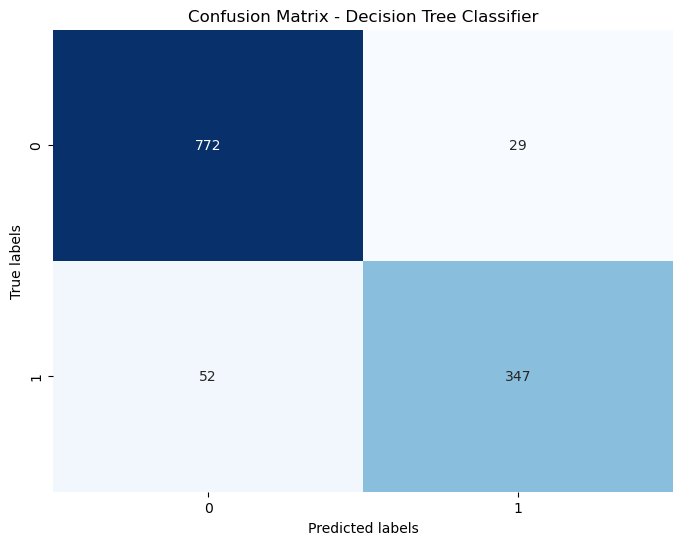

In [107]:
# Confusion matrix for Decision Tree
dt_conf_matrix = confusion_matrix(y_test, dt_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(dt_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()

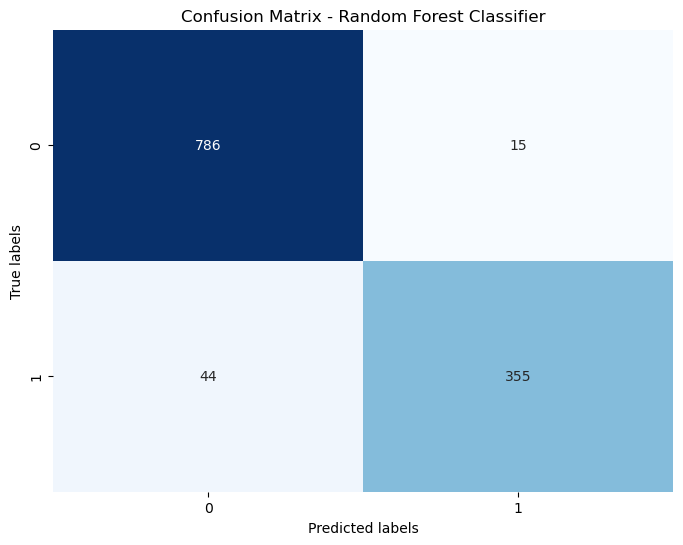

In [108]:
# Confusion matrix for Random Forest
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()